In [1]:
from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
import time
!pip install captum
from captum.attr import LayerGradCam
from captum.attr import visualization
import cv2 as cv

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
BATCH_SIZE = 8
NUM_WORKERS = 4

NUM_CLASSES = 10

NUM_EPOCHS = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/data', train=False, download=True, transform=transform)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self, num_classes):
    super(ConvolutionalNeuralNetwork, self).__init__()

    self.conv_0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
    self.relu_0 = nn.ReLU()
    self.maxpool2d_0 = nn.MaxPool2d(kernel_size=2)

    self.conv_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
    self.relu_1 = nn.ReLU()
    self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2)

    self.flatten_0 = nn.Flatten()

    self.linear_0 = nn.Linear(16*5*5, 128)
    self.relu_2 = nn.ReLU()

    self.linear_1 = nn.Linear(128, 64)
    self.relu_3 = nn.ReLU()

    self.linear_2 = nn.Linear(64, num_classes)

  def forward(self, X):
    X = self.conv_0(X)
    X = self.relu_0(X)
    X = self.maxpool2d_0(X)

    X = self.conv_1(X)
    X = self.relu_1(X)
    X = self.maxpool2d_1(X)

    X = self.flatten_0(X)

    X = self.linear_0(X)
    X = self.relu_2(X)

    X = self.linear_1(X)
    X = self.relu_3(X)

    X = self.linear_2(X)

    return X

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convolutional = ConvolutionalNeuralNetwork(num_classes=NUM_CLASSES)
convolutional = convolutional.to(device)

In [8]:
def train_model(model, train_dataloader, val_dataloader, loss_function, epochs, learning_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_epoch_losses = []
  train_epoch_accuracies = []

  val_epoch_losses = []
  val_epoch_accuracies = []

  for epoch in range(epochs):
    model.train()

    train_current_epoch_loss = 0.0
    train_current_epoch_correct_predictions = 0
    train_current_epoch_total_predictions = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_function(outputs, y_batch)
      loss.backward()
      optimizer.step()

      train_current_epoch_loss += loss.item()
      train_current_epoch_correct_predictions += (outputs.argmax(dim=1) == y_batch).sum().item()
      train_current_epoch_total_predictions += y_batch.size(0)

    train_epoch_losses.append(train_current_epoch_loss / len(train_dataloader))
    train_epoch_accuracies.append(train_current_epoch_correct_predictions / train_current_epoch_total_predictions)

    print(f'Training, Epoch {epoch + 1}/{epochs}, Loss: {train_epoch_losses[-1]}, Accuracy: {train_epoch_accuracies[-1]}')

    model.eval()

    val_current_epoch_loss = 0.0
    val_current_epoch_correct_predictions = 0
    val_current_epoch_total_predictions = 0

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in enumerate(val_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)

        val_current_epoch_loss += loss.item()
        val_current_epoch_correct_predictions += (outputs.argmax(dim=1) == y_batch).sum().item()
        val_current_epoch_total_predictions += y_batch.size(0)

    val_epoch_losses.append(val_current_epoch_loss / len(val_dataloader))
    val_epoch_accuracies.append(val_current_epoch_correct_predictions / val_current_epoch_total_predictions)

    print(f'Validation, Epoch {epoch + 1}/{epochs}, Loss: {val_epoch_losses[-1]}, Accuracy: {val_epoch_accuracies[-1]}')

  return train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies

In [9]:
def plot_train_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_epoch_losses, label='Training Loss', color='blue')
  plt.plot(val_epoch_losses, label='Validation Loss', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_epoch_accuracies, label='Training Accuracy', color='blue')
  plt.plot(val_epoch_accuracies, label='Validation Accuracy', color='red')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracies')
  plt.legend()

  plt.tight_layout()
  plt.show()

Training, Epoch 1/5, Loss: 1.5710933320939542, Accuracy: 0.425825
Validation, Epoch 1/5, Loss: 1.3660852634191514, Accuracy: 0.508
Training, Epoch 2/5, Loss: 1.2992055381000043, Accuracy: 0.5349
Validation, Epoch 2/5, Loss: 1.256675773191452, Accuracy: 0.5446
Training, Epoch 3/5, Loss: 1.1835431359499693, Accuracy: 0.5794
Validation, Epoch 3/5, Loss: 1.1604743456959725, Accuracy: 0.5871
Training, Epoch 4/5, Loss: 1.0992416832149028, Accuracy: 0.6115
Validation, Epoch 4/5, Loss: 1.1437847191929817, Accuracy: 0.5969
Training, Epoch 5/5, Loss: 1.0388555754892528, Accuracy: 0.63045
Validation, Epoch 5/5, Loss: 1.1225022644758225, Accuracy: 0.6069


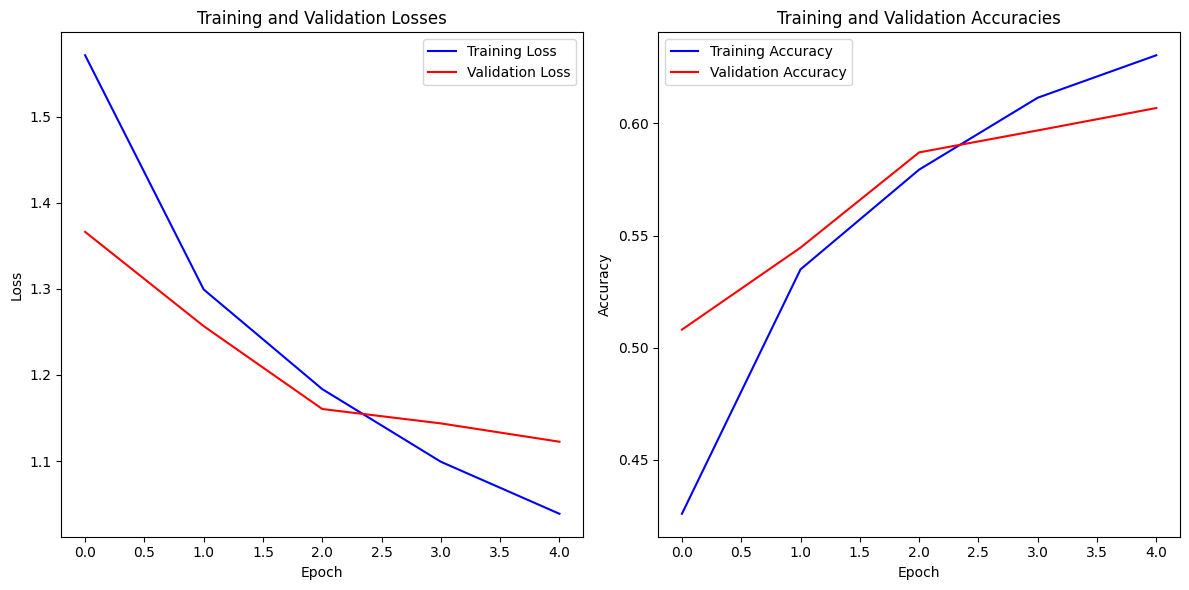

In [10]:
train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies = train_model(convolutional, train_dataloader, val_dataloader, nn.CrossEntropyLoss(), NUM_EPOCHS, LEARNING_RATE)
plot_train_results(train_epoch_losses, train_epoch_accuracies, val_epoch_losses, val_epoch_accuracies)

In [11]:
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, device=None):
    super(myLinear, self).__init__()

    self.in_features = in_features
    self.out_features = out_features

    self.weight = nn.parameter.Parameter(torch.empty(out_features, in_features, device=device))
    self.bias = nn.parameter.Parameter(torch.empty(out_features, device=device))

    self.reset_parameters()

  def reset_parameters(self):
    scale = 1.0 / np.sqrt(self.in_features)

    nn.init.uniform_(self.weight, -scale, scale)
    nn.init.uniform_(self.bias, -scale, scale)

  def forward(self, X):
    expanded_X = X.unsqueeze(dim=2)
    y = torch.matmul(self.weight, expanded_X)
    expanded_bias = self.bias.unsqueeze(dim=0).unsqueeze(dim=2)
    y = y + expanded_bias
    y = y.squeeze(dim=2)
    return y

In [12]:
linear = nn.Linear(in_features=8, out_features=16, device=device).to(device)
my_linear = myLinear(in_features=8, out_features=16, device=device).to(device)

random_input = torch.randn(8)
random_input = random_input.unsqueeze(dim=0)
random_input = random_input.to(device)

print('Mean Absolute Difference before copy:', torch.mean(torch.abs(linear(random_input) - my_linear(random_input))).item())

my_linear.load_state_dict(linear.state_dict())

print('Mean Absolute Difference after copy:', torch.mean(torch.abs(linear(random_input) - my_linear(random_input))).item())

Mean Absolute Difference before copy: 0.7548699378967285
Mean Absolute Difference after copy: 0.0


In [13]:
class myConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
    super(myConv2d, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.padding = padding
    self.stride = stride

    scale = 1.0 / np.sqrt(in_channels * kernel_size * kernel_size)

    self.weight = nn.parameter.Parameter(torch.rand(out_channels, in_channels, kernel_size, kernel_size))
    self.bias = nn.parameter.Parameter(torch.rand(out_channels))

    self.reset_parameters()

  def reset_parameters(self):
    scale = 1.0 / np.sqrt(self.in_channels * self.kernel_size * self.kernel_size)

    nn.init.uniform_(self.weight, -scale, scale)
    nn.init.uniform_(self.bias, -scale, scale)

  def forward(self, X):
    batch_size = X.shape[0]
    num_channels = X.shape[1]
    image_height = X.shape[2]
    image_width = X.shape[3]

    y = torch.zeros(
      batch_size,
      self.out_channels,
      (image_height + 2 * self.padding - self.kernel_size // 2 - self.kernel_size // 2) // self.stride,
      (image_width + 2 * self.padding - self.kernel_size // 2 - self.kernel_size // 2) // self.stride
    ).to(device)

    if self.padding > 0:
      X = nn.functional.pad(X, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=0)

    for image_idx in range(batch_size):
      for i in range(self.kernel_size // 2, image_height + 2 * self.padding - self.kernel_size // 2, self.stride):
        for j in range(self.kernel_size // 2, image_width + 2 * self.padding - self.kernel_size // 2, self.stride):
          y[image_idx, : , i - self.kernel_size // 2, j - self.kernel_size // 2] = torch.sum(
              self.weight *
              X[image_idx, : ,
                i - self.kernel_size // 2 : i + self.kernel_size // 2 + 1,
                j - self.kernel_size // 2 : j + self.kernel_size // 2 + 1], dim=(1, 2, 3)
          ) + self.bias

    return y

In [14]:
conv2d = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1).to(device)
my_conv2d = myConv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1).to(device)

CHOSEN_IMAGES_SIZE = 16
permutation = torch.randperm(len(train_dataset))[:CHOSEN_IMAGES_SIZE]
chosen_images = Subset(train_dataset, permutation)

sum_absolute_difference = 0.0
for image, label in chosen_images:
  sum_absolute_difference += torch.abs(conv2d(image.unsqueeze(dim=0).to(device)) - my_conv2d(image.unsqueeze(dim=0).to(device))).sum().item()
print('Mean Absolute Difference before copy:', sum_absolute_difference / CHOSEN_IMAGES_SIZE)

my_conv2d.load_state_dict(conv2d.state_dict())

sum_absolute_difference = 0.0
for image, label in chosen_images:
  sum_absolute_difference += torch.abs(conv2d(image.unsqueeze(dim=0).to(device)) - my_conv2d(image.unsqueeze(dim=0).to(device))).sum().item()
print('Mean Absolute Difference after copy:', sum_absolute_difference / CHOSEN_IMAGES_SIZE)

Mean Absolute Difference before copy: 1967.0037536621094
Mean Absolute Difference after copy: 0.0002168155915569514


In [15]:
class myConvolutionalNeuralNetwork(nn.Module):
  def __init__(self, num_classes):
    super(myConvolutionalNeuralNetwork, self).__init__()

    self.conv_0 = myConv2d(in_channels=3, out_channels=8, kernel_size=5)
    self.relu_0 = nn.ReLU()
    self.maxpool2d_0 = nn.MaxPool2d(kernel_size=2)

    self.conv_1 = myConv2d(in_channels=8, out_channels=16, kernel_size=5)
    self.relu_1 = nn.ReLU()
    self.maxpool2d_1 = nn.MaxPool2d(kernel_size=2)

    self.flatten_0 = nn.Flatten()

    self.linear_0 = myLinear(16*5*5, 128)
    self.relu_2 = nn.ReLU()

    self.linear_1 = myLinear(128, 64)
    self.relu_3 = nn.ReLU()

    self.linear_2 = myLinear(64, num_classes)

  def forward(self, X):
    X = self.conv_0(X)
    X = self.relu_0(X)
    X = self.maxpool2d_0(X)

    X = self.conv_1(X)
    X = self.relu_1(X)
    X = self.maxpool2d_1(X)

    X = self.flatten_0(X)

    X = self.linear_0(X)
    X = self.relu_2(X)

    X = self.linear_1(X)
    X = self.relu_3(X)

    X = self.linear_2(X)

    return X

In [16]:
my_convolutional = myConvolutionalNeuralNetwork(num_classes=NUM_CLASSES)
my_convolutional = my_convolutional.to(device)

my_convolutional.load_state_dict(convolutional.state_dict())

<All keys matched successfully>

In [17]:
def compute_accuracy_and_time(model, chosen_images):
  images = torch.stack([image[0] for image in chosen_images])
  labels = torch.tensor([image[1] for image in chosen_images])

  num_correct_predictions = 0
  num_total_predictions = 0

  if device == 'cuda':
    torch.cuda.synchronize()
  start_time = time.time()


  model.eval()

  with torch.no_grad():

    '''
    for image, label in zip(images, labels):
      image = image.unsqueeze(dim=0).to(device)
      label = label.unsqueeze(dim=0).to(device)

      outputs = model(image)

      num_correct_predictions += (outputs.argmax(dim=1) == label).sum().item()
      num_total_predictions += label.size(0)
    '''

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    num_correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
    num_total_predictions += labels.size(0)

  if device == 'cuda':
    torch.cuda.synchronize()
  end_time = time.time()

  return num_correct_predictions / num_total_predictions, (end_time - start_time) / len(chosen_images)

In [18]:
CHOSEN_IMAGES_SIZE = 20
permutation = torch.randperm(len(train_dataset))[:CHOSEN_IMAGES_SIZE]
chosen_images = Subset(train_dataset, permutation)

convolutional_accuracy, convolutional_time = compute_accuracy_and_time(convolutional, chosen_images)
my_convolutional_accuracy, my_convolutional_time = compute_accuracy_and_time(my_convolutional, chosen_images)

print('Convolutional Accuracy:', convolutional_accuracy)
print('Convolutional Time:', convolutional_time)
print('My Convolutional Accuracy:', my_convolutional_accuracy)
print('My Convolutional Time:', my_convolutional_time)

print('Time Ratio:', my_convolutional_time / convolutional_time)

Convolutional Accuracy: 0.6
Convolutional Time: 0.00016313791275024414
My Convolutional Accuracy: 0.6
My Convolutional Time: 0.06590697765350342
Time Ratio: 403.9954694921447


In [19]:
def normalize01(image):
  EPSILON = 1e-6
  return (image - np.min(image)) / (np.max(image) - np.min(image) + EPSILON)

def plot_activations(model, chosen_images):
  images = torch.stack([image[0] for image in chosen_images])

  model.eval()

  activations = dict()
  def get_activation(name):
    def hook(model, input, output):
      activations[name] = output.detach()
    return hook

  hook_conv_0 = model.conv_0.register_forward_hook(get_activation('conv_0'))
  hook_maxpool2d_0 = model.maxpool2d_0.register_forward_hook(get_activation('maxpool2d_0'))

  hook_conv_1 = model.conv_1.register_forward_hook(get_activation('conv_1'))
  hook_maxpool2d_1 = model.maxpool2d_1.register_forward_hook(get_activation('maxpool2d_1'))

  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)

  hook_conv_0.remove()
  hook_maxpool2d_0.remove()

  hook_conv_1.remove()
  hook_maxpool2d_1.remove()

  fig, axes = plt.subplots(1, images.shape[0], figsize=(12, 6))
  for i in range(images.shape[0]):
    axes[i].imshow(normalize01(images[i].cpu().numpy().transpose(1, 2, 0)))
    axes[i].axis('off')
  plt.suptitle('Original Images')
  plt.tight_layout()
  plt.show()

  for layer_name, activation in activations.items():
    fig, axes = plt.subplots(activation.shape[0], np.minimum(activation.shape[1], 5), figsize=(12, 6))
    for i in range(activation.shape[0]):
      for j in range(np.minimum(activation.shape[1], 5)):
        axes[i, j].imshow(normalize01(activation[i, j].cpu().numpy()), cmap='gray')
        axes[i, j].axis('off')
    plt.suptitle(f'{layer_name} Layer')
    plt.tight_layout()
    plt.show()

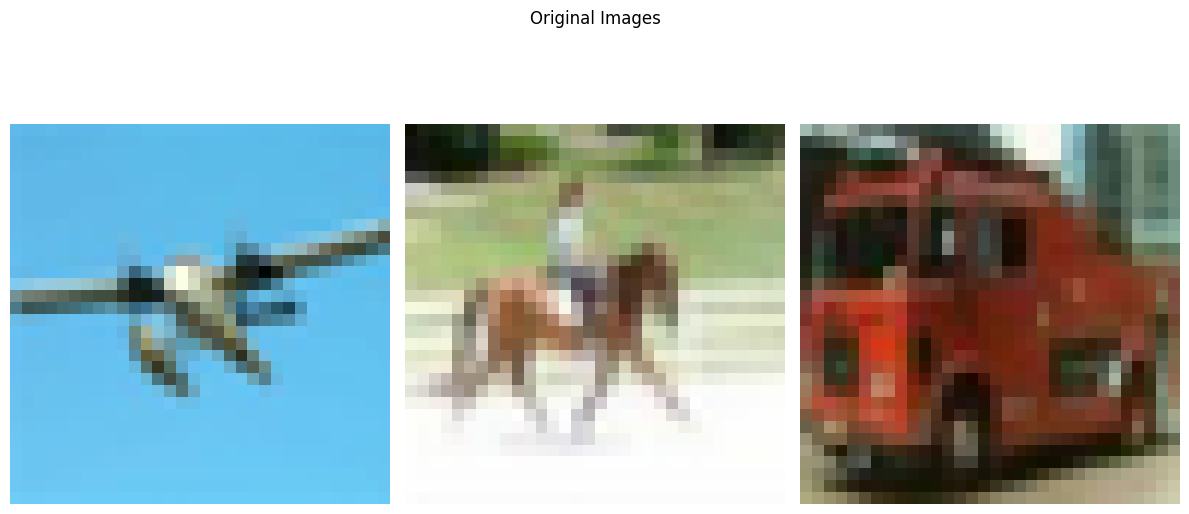

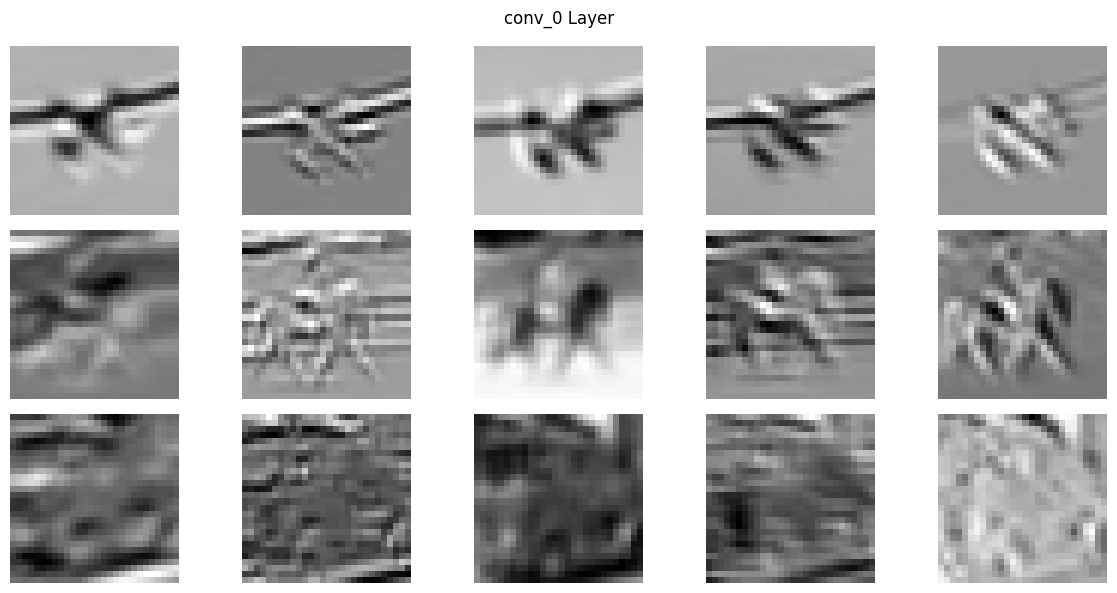

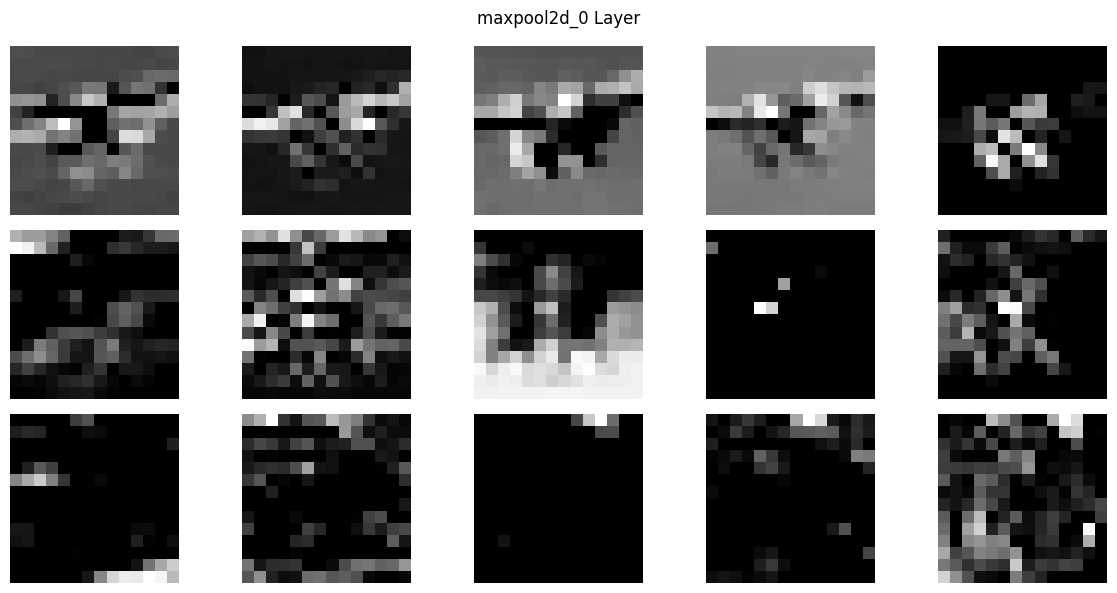

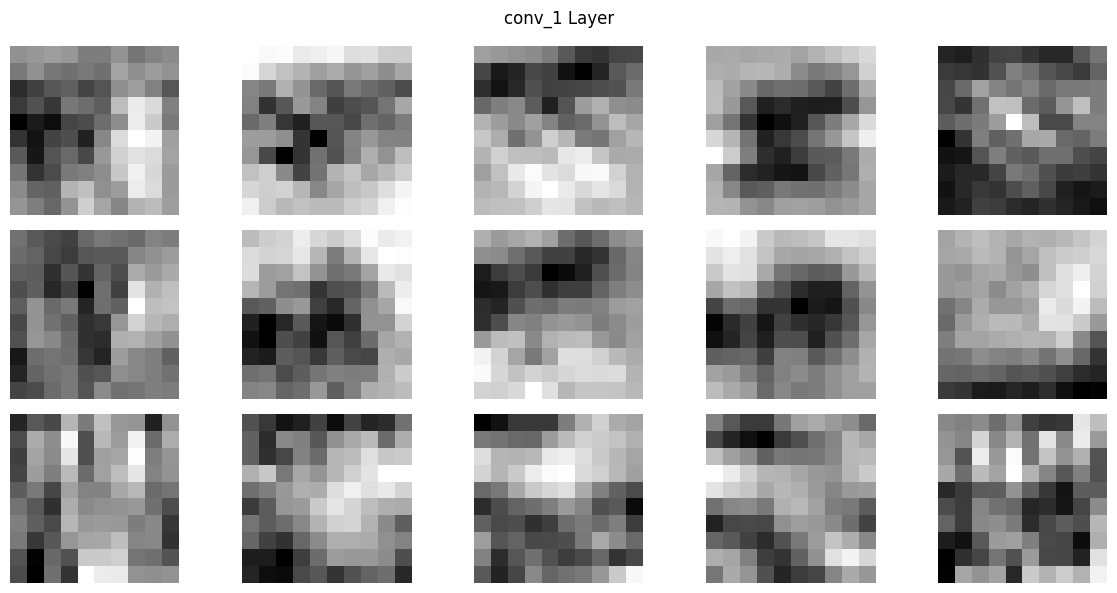

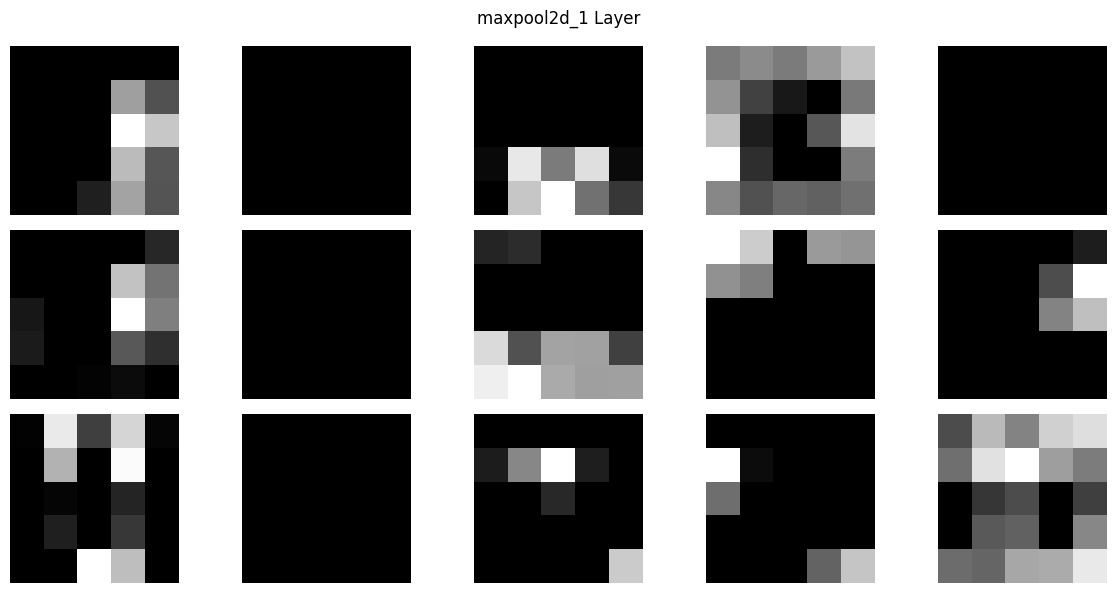

In [20]:
CHOSEN_IMAGES_SIZE = 3
permutation = torch.randperm(len(train_dataset))[:CHOSEN_IMAGES_SIZE]
chosen_images = Subset(train_dataset, permutation)

plot_activations(convolutional, chosen_images)

In [21]:
def get_images_from_dataset(model, dataset, num_correct_samples, num_wrong_samples):
  model.eval()

  images = torch.stack([image for image, _ in dataset])
  labels = torch.tensor([label for _, label in dataset])

  correct_sample_idx = []
  wrong_sample_idx = []

  with torch.no_grad():
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    predictions = outputs.argmax(dim=1)

    for i in range(images.shape[0]):
      if predictions[i] == labels[i]:
        correct_sample_idx.append(i)
      else:
        wrong_sample_idx.append(i)

  if len(correct_sample_idx) < num_correct_samples:
    raise Exception('Not enough correct samples')
  if len(wrong_sample_idx) < num_wrong_samples:
    raise Exception('Not enough wrong samples')

  correct_selected_sample_idx = np.random.choice(correct_sample_idx, num_correct_samples, replace=False)
  wrong_selected_sample_idx = np.random.choice(wrong_sample_idx, num_wrong_samples, replace=False)

  correct_samples = images[correct_selected_sample_idx]
  wrong_samples = images[wrong_selected_sample_idx]

  return correct_samples, wrong_samples

In [22]:
def get_attribute(model, sample):
    model.eval()

    grad_cam = LayerGradCam(model, model.conv_1)

    attribute = grad_cam.attribute(sample.unsqueeze(0), target=0)

    return attribute


def plot_gradcam_for_sample(sample, attribute, is_correct_sample):
  sample = sample.cpu().numpy().transpose(1, 2, 0)
  sample = normalize01(sample)

  attribute = attribute.detach().cpu().numpy()

  attribute = np.maximum(attribute, 0.0)
  attribute = normalize01(attribute)
  attribute = np.squeeze(attribute, axis=(0, 1))
  attribute = cv.resize(attribute, (sample.shape[1], sample.shape[0]))

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  axes[0].imshow(sample)
  axes[0].axis('off')
  if is_correct_sample:
    axes[0].set_title('Original Image (Correct Sample)')
  else:
    axes[0].set_title('Original Image (Wrong Sample)')

  axes[1].imshow(sample)
  axes[1].imshow(attribute, cmap='jet', alpha=0.5)
  axes[1].axis('off')
  if is_correct_sample:
    axes[1].set_title('Overlayed GradCam (Correct Sample)')
  else:
    axes[1].set_title('Overlayed GradCam (Wrong Sample)')

  plt.tight_layout()
  plt.show()


def plot_gradcams(model, correct_samples, wrong_samples):
  for correct_sample in correct_samples:
    attribute = get_attribute(model, correct_sample)
    plot_gradcam_for_sample(correct_sample, attribute, True)

  for wrong_sample in wrong_samples:
    attribute = get_attribute(model, wrong_sample)
    plot_gradcam_for_sample(wrong_sample, attribute, False)

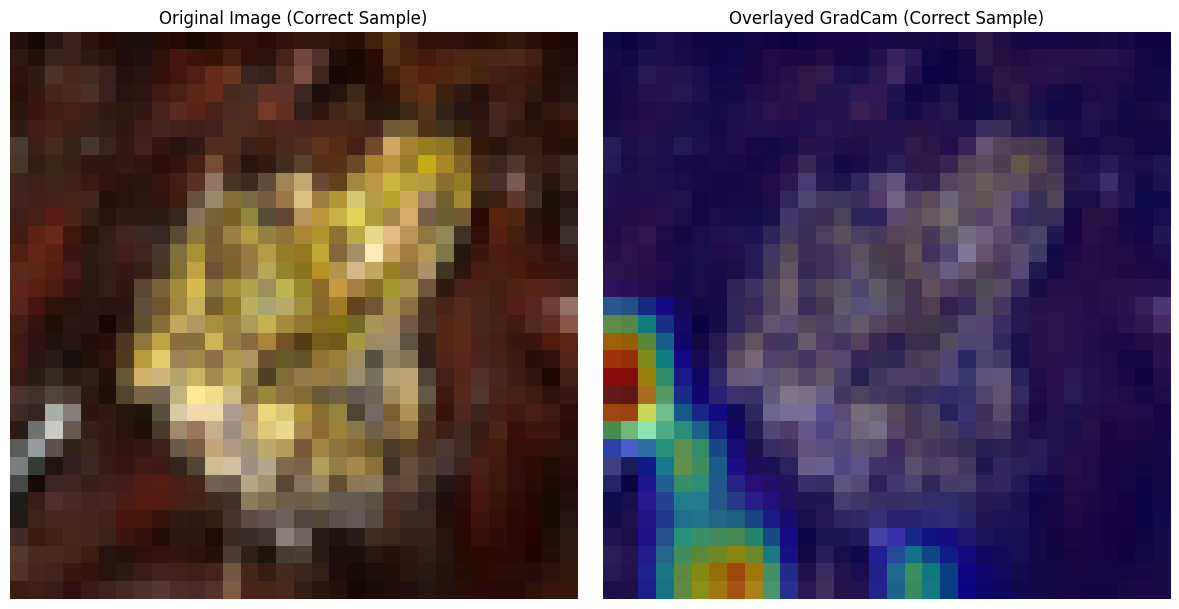

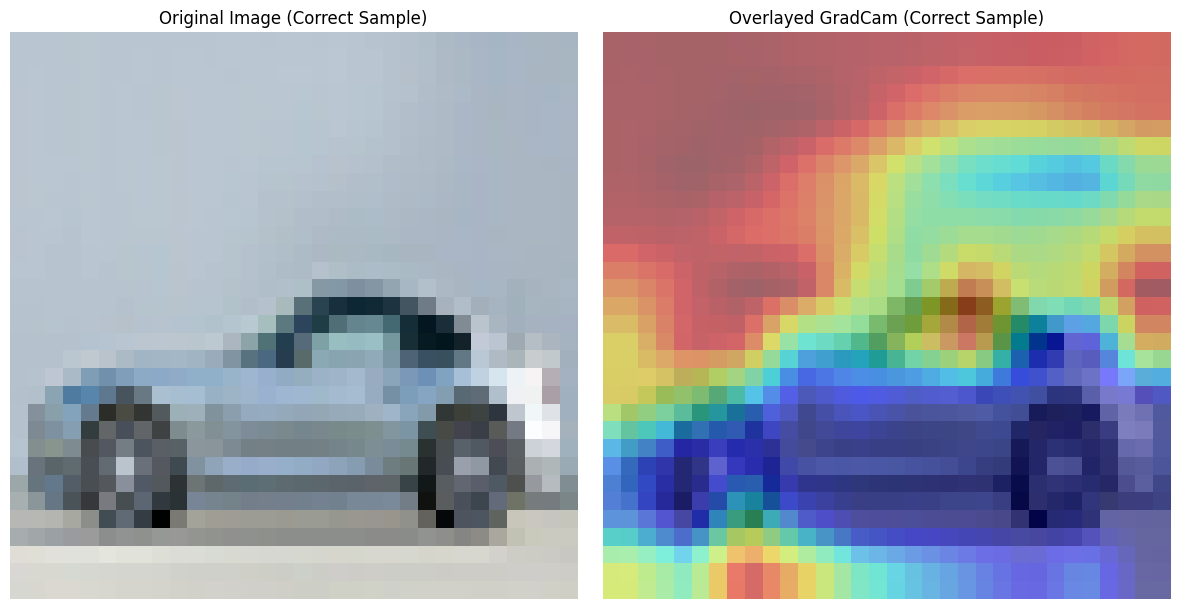

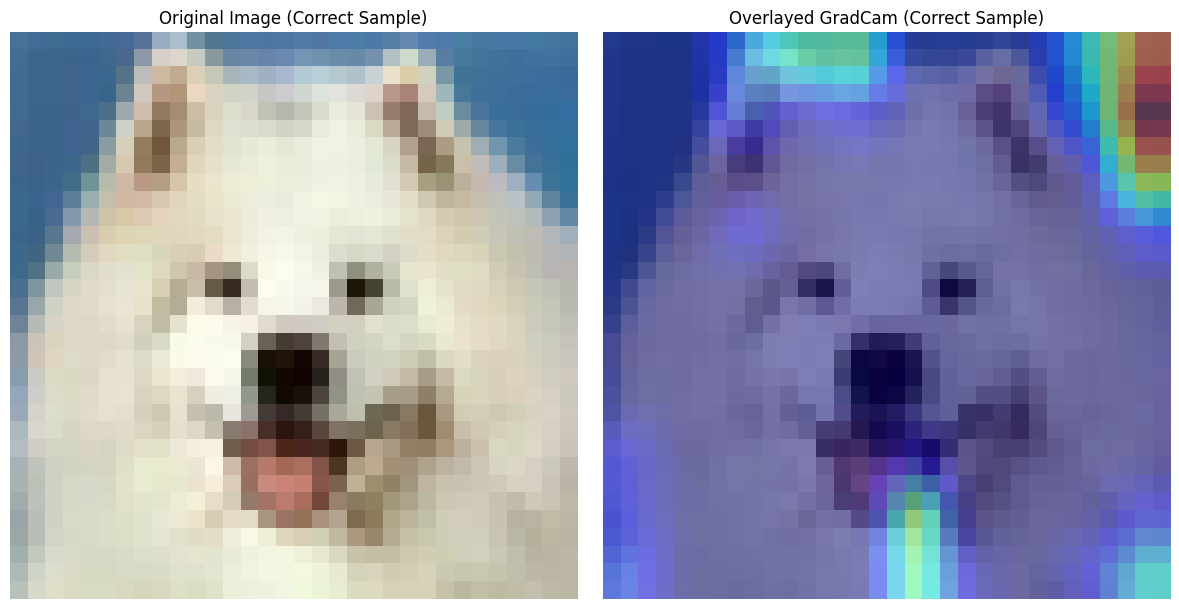

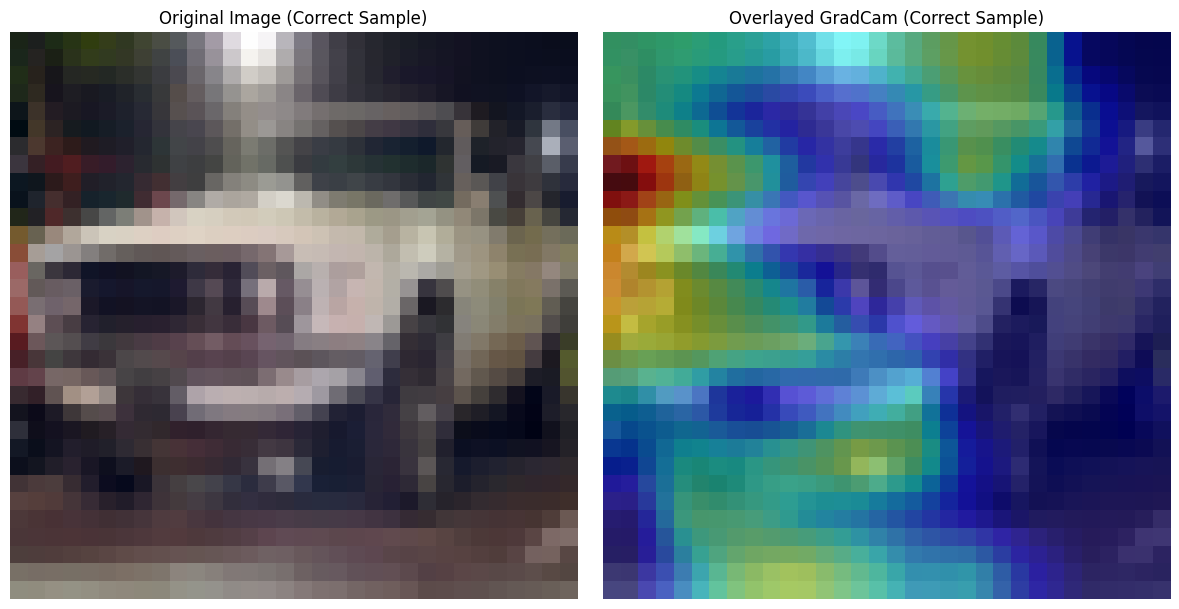

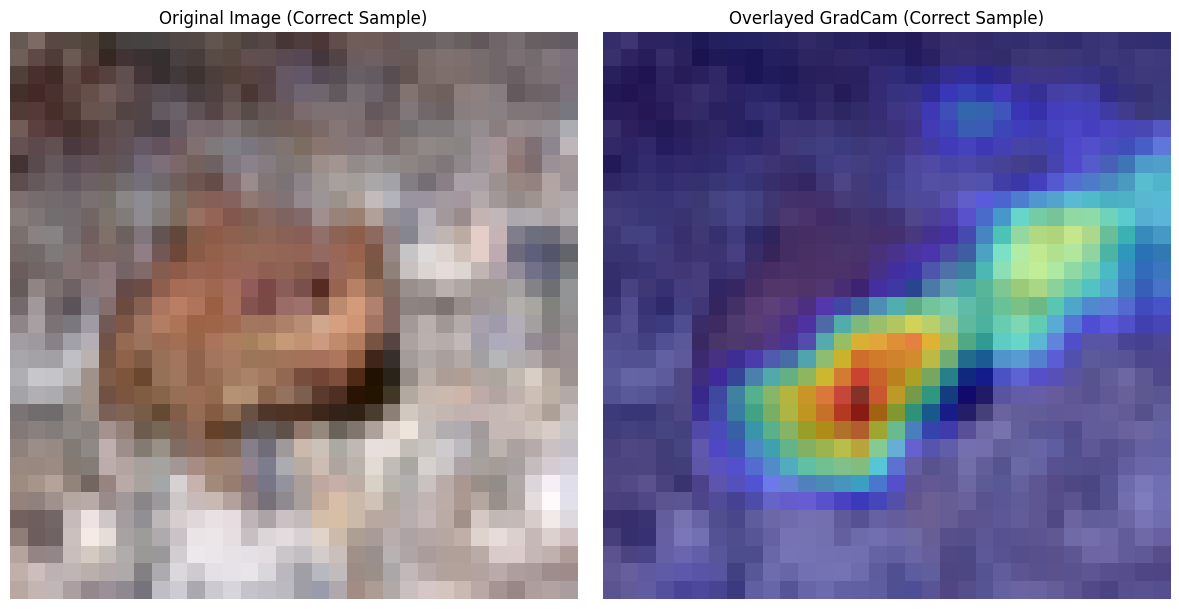

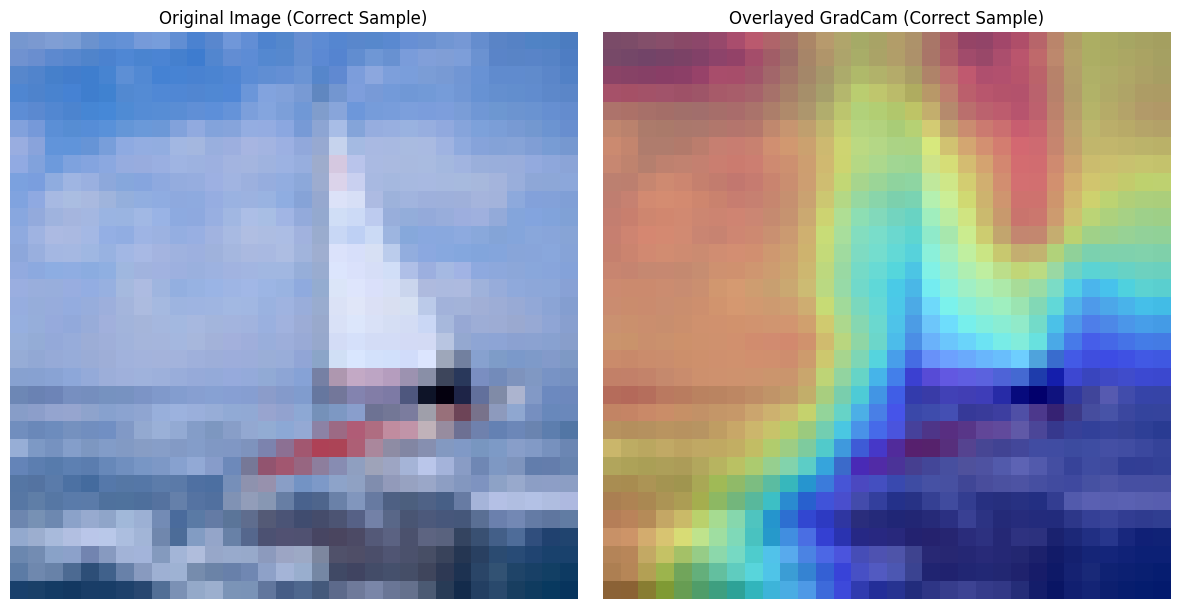

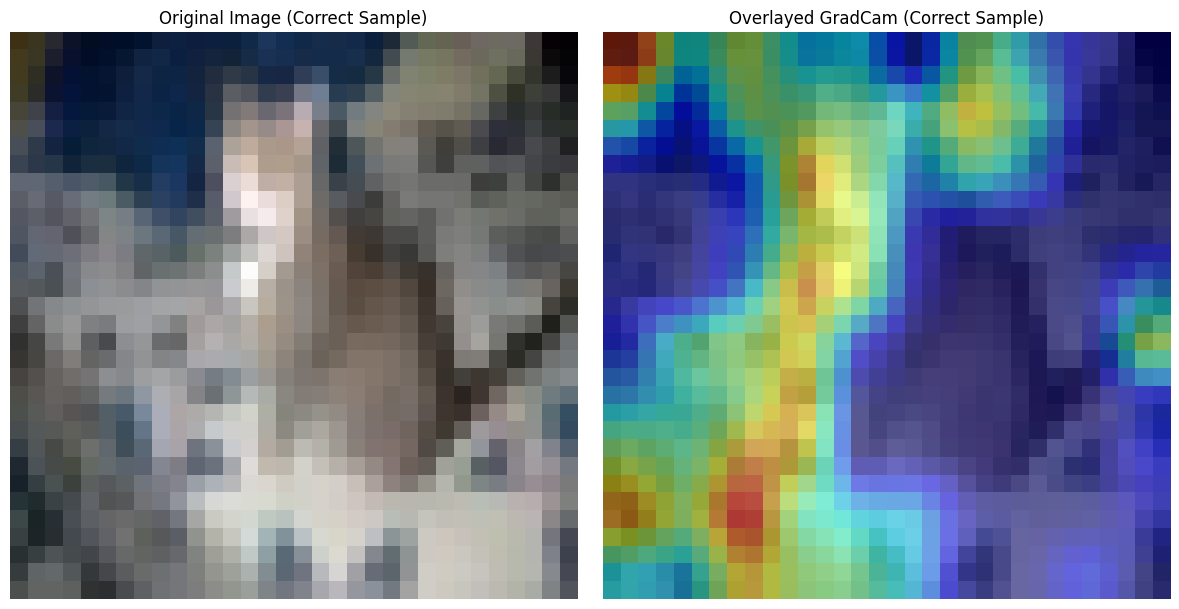

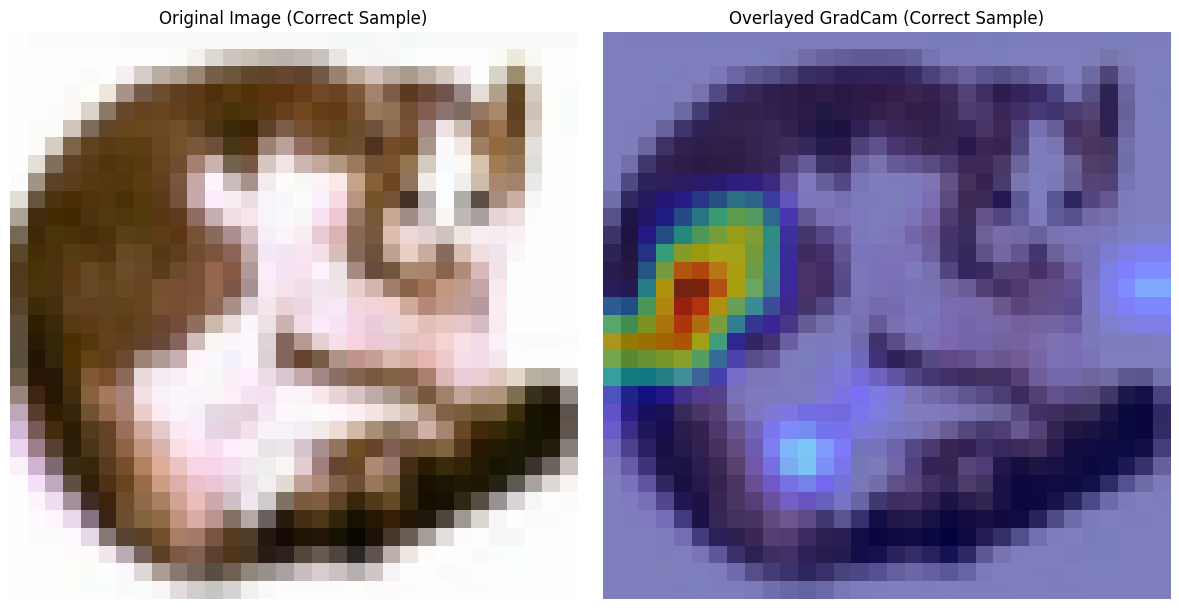

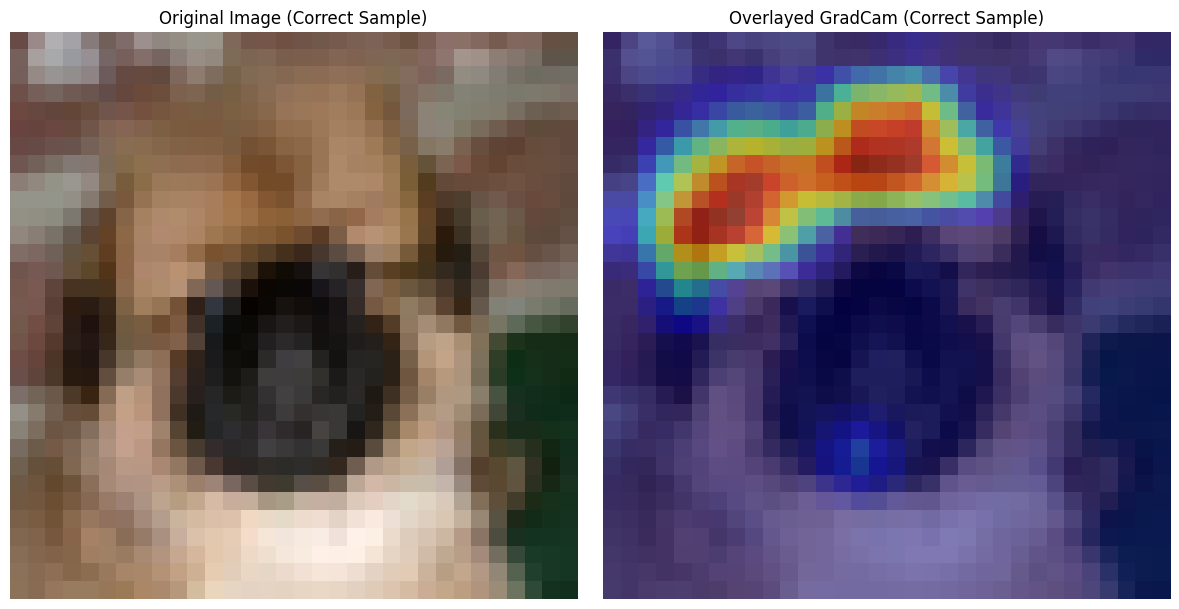

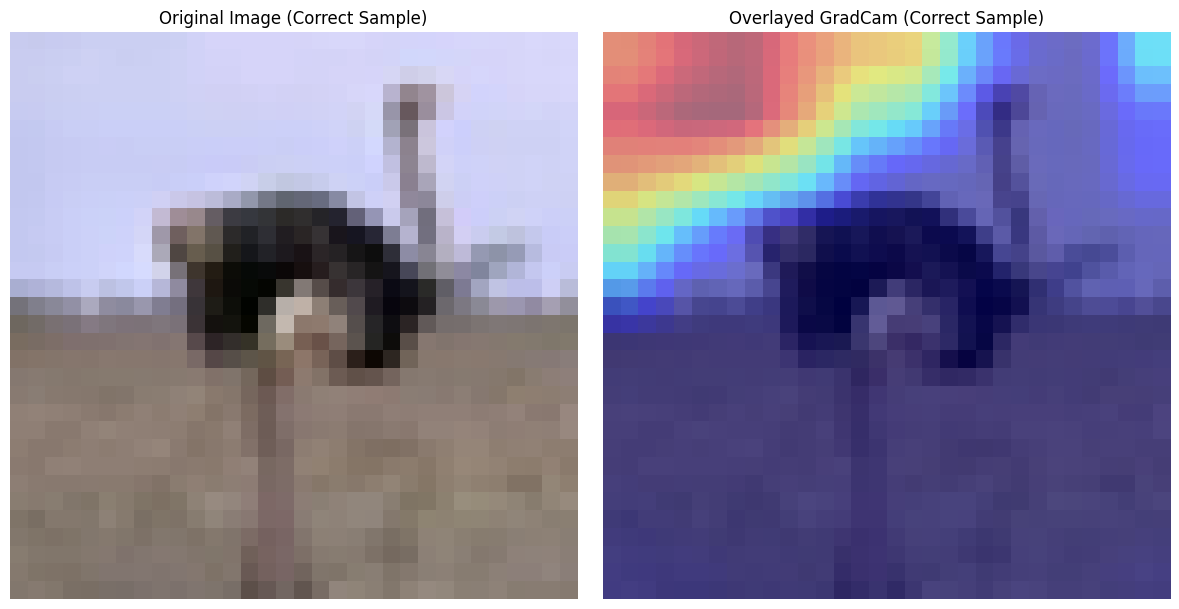

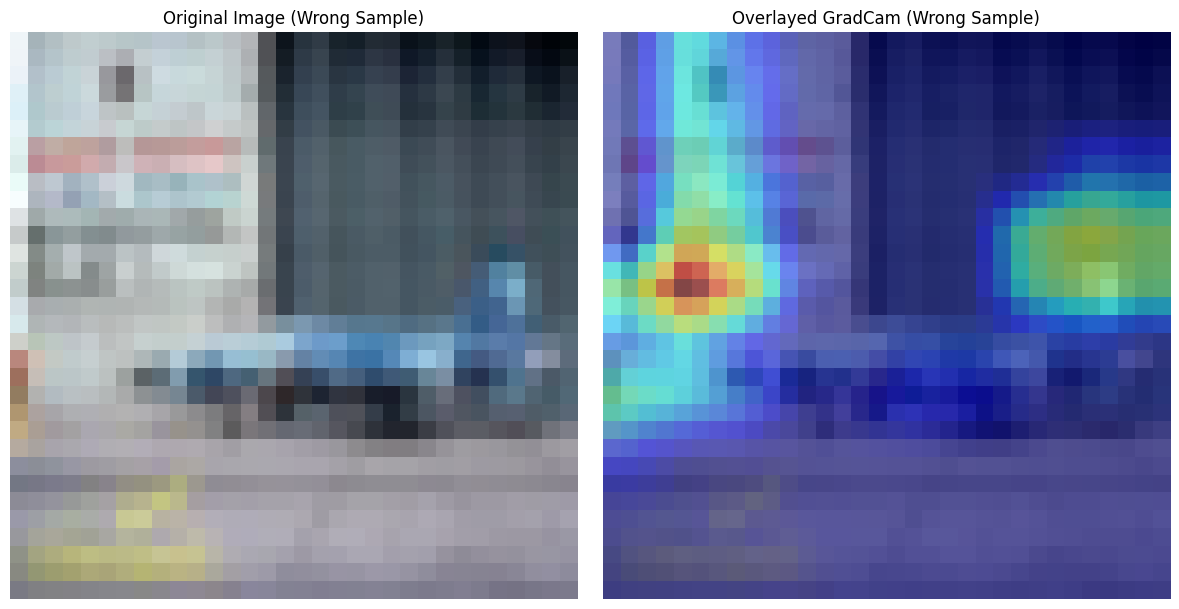

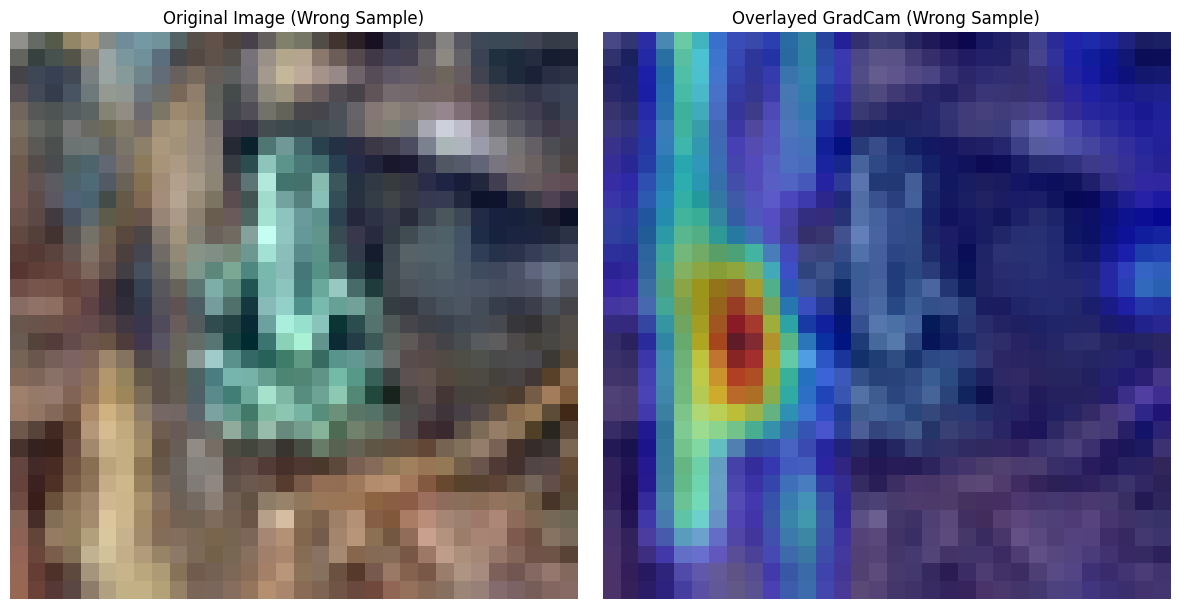

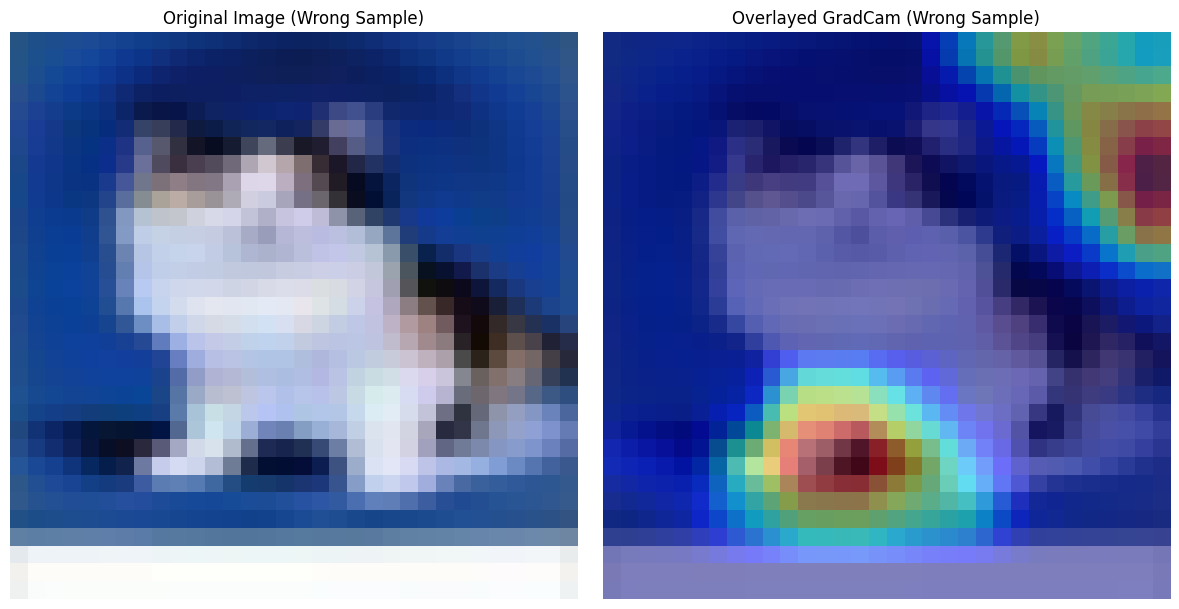

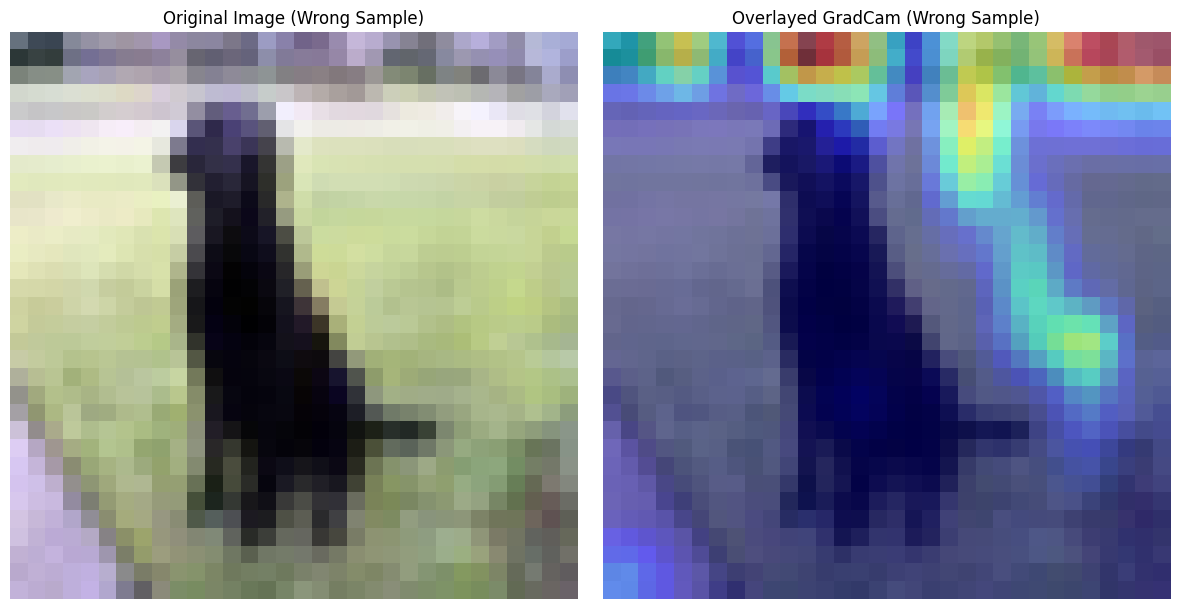

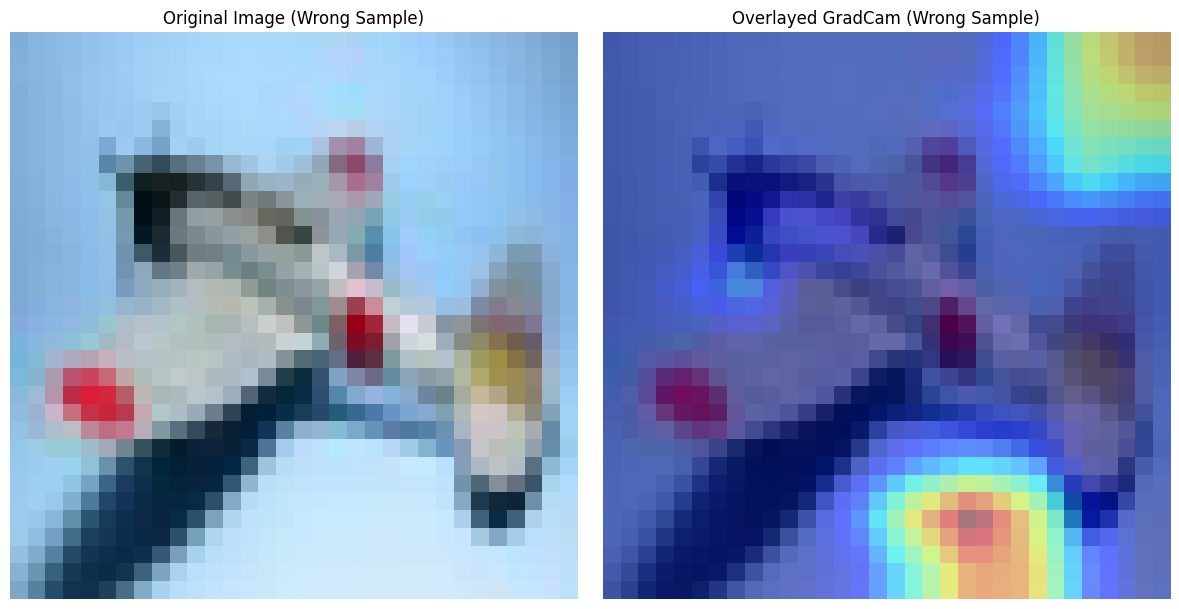

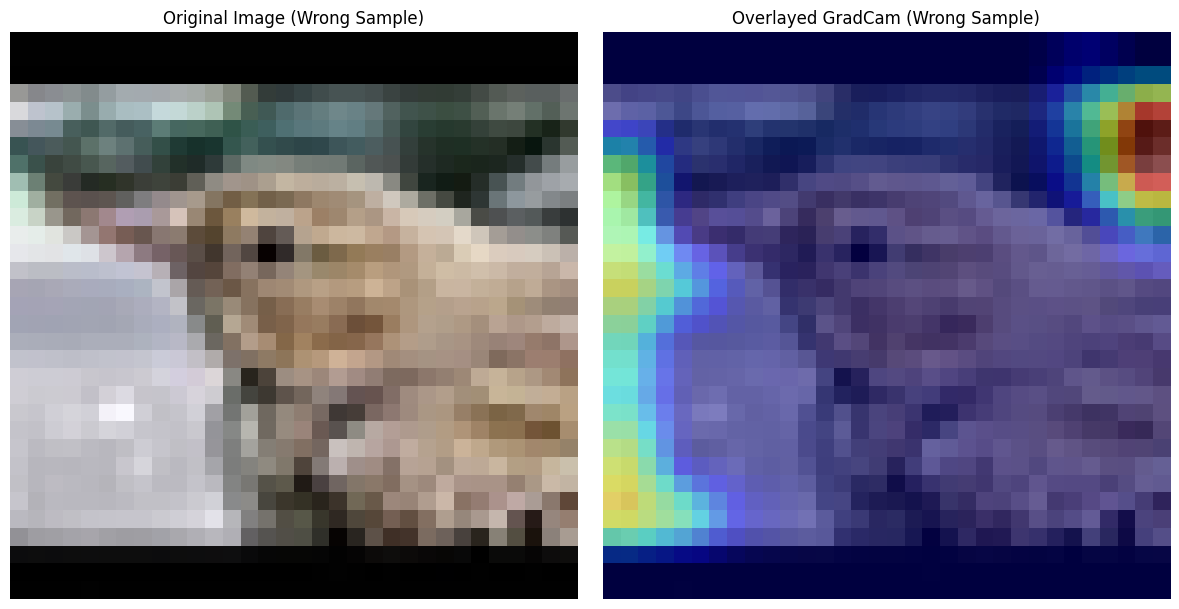

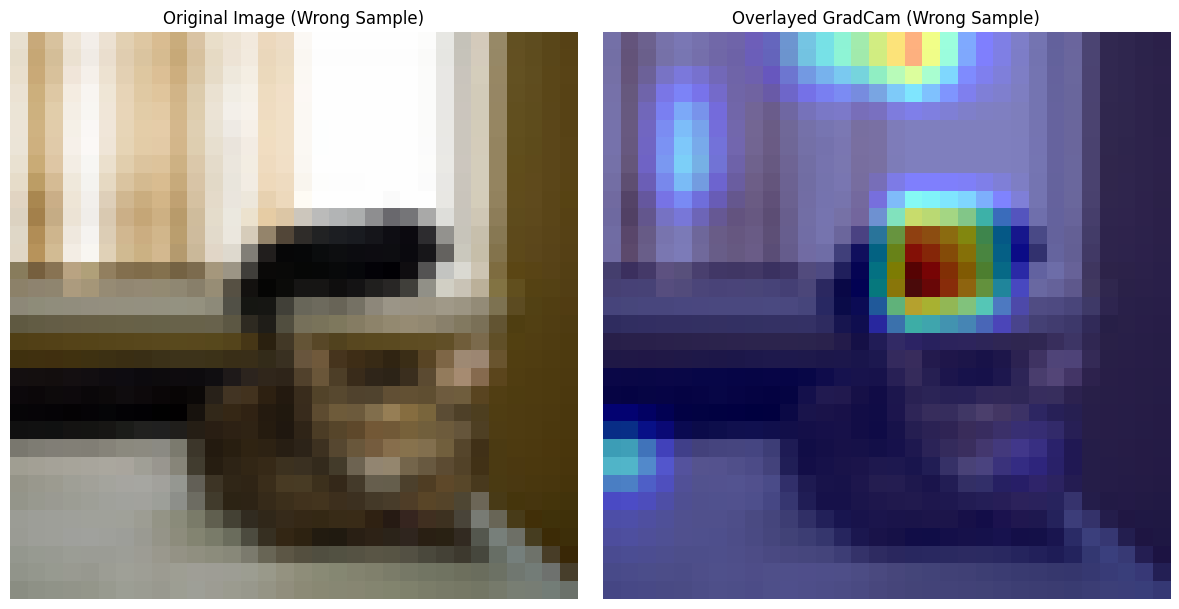

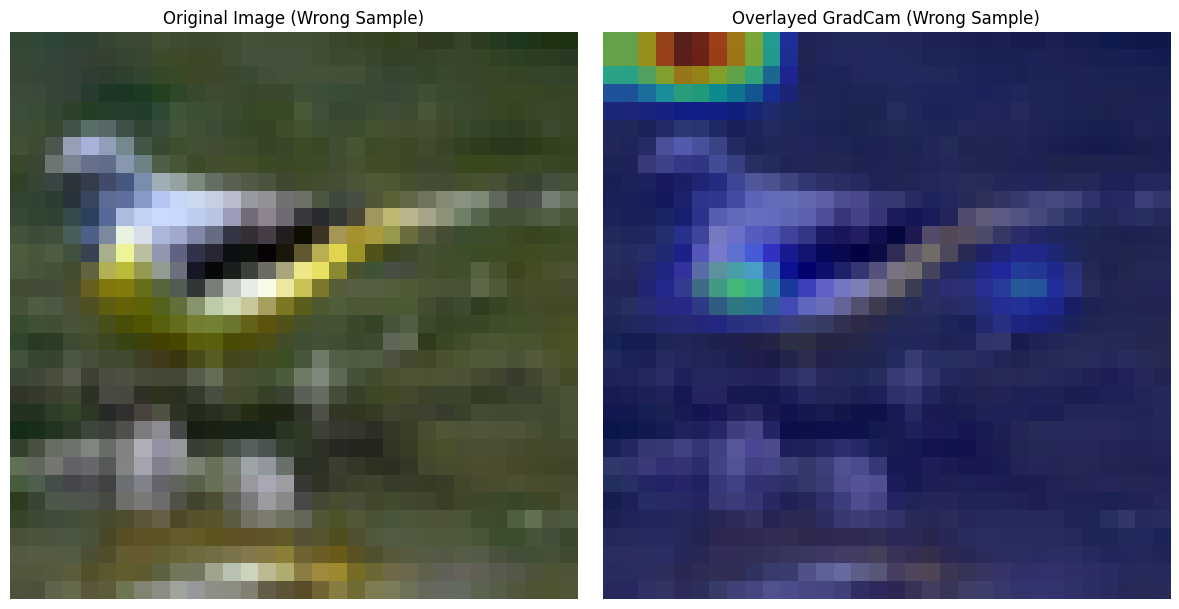

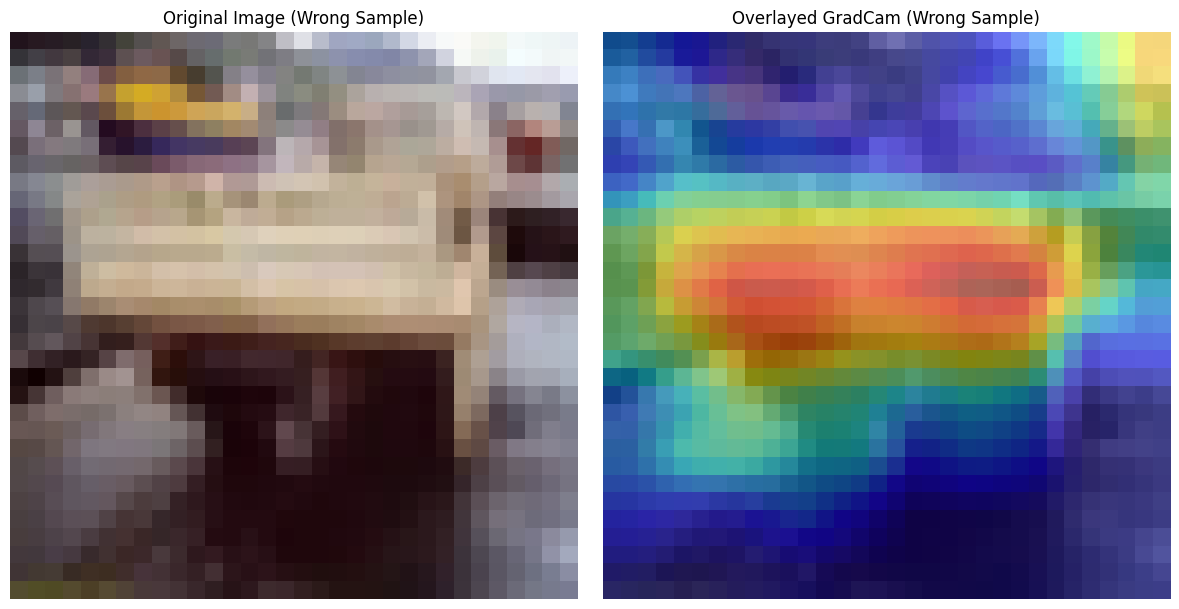

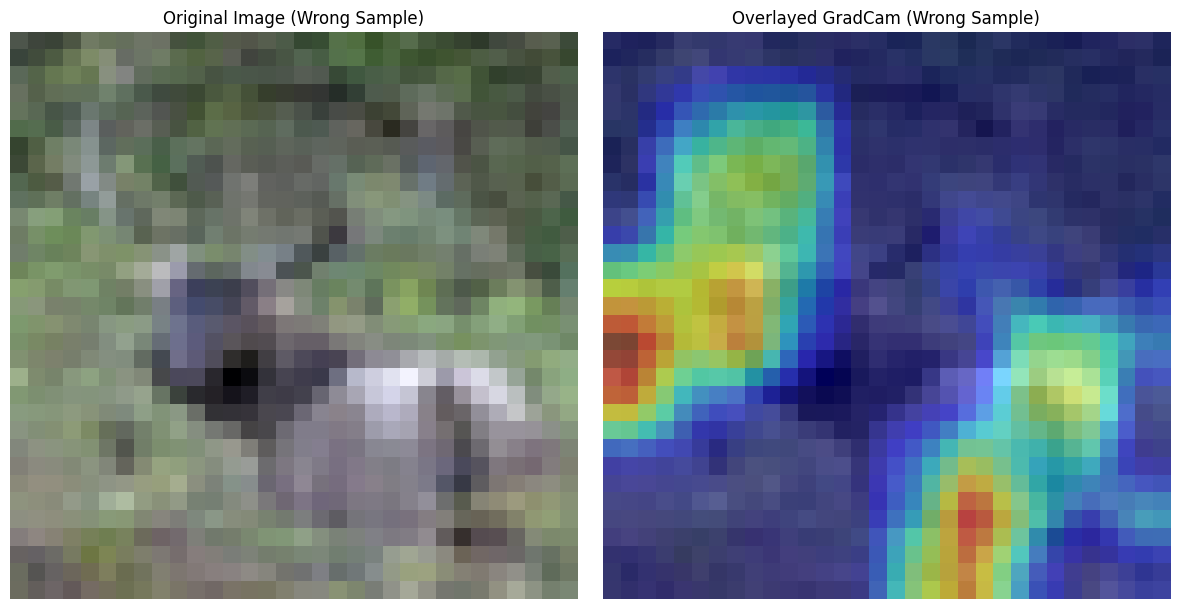

In [23]:
NUM_CORRECT_SAMPLES = 10
NUM_WRONG_SAMPLES = 10

correct_samples, wrong_samples = get_images_from_dataset(convolutional, test_dataset, NUM_CORRECT_SAMPLES, NUM_WRONG_SAMPLES)

plot_gradcams(convolutional, correct_samples, wrong_samples)